## Gated PixelCNN
PixelCNN is an autoregressive likelihood model for the task of image modeling, and Gated PixelCNN is an improved version, which uses GatedMaskedConv.

### Reference
- https://keras.io/examples/generative/pixelcnn/
- Pixel Recurrent Neural Networks: https://arxiv.org/abs/1601.06759
- Conditional Image Generation with PixelCNN Decoders: https://arxiv.org/abs/1606.05328
- https://uvadlc-notebooks.readthedocs.io/en/latest/tutorial_notebooks/tutorial12/Autoregressive_Image_Modeling.html

In [1]:
import os
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import datasets, transforms
from sklearn.manifold import TSNE
import pandas as pd
import matplotlib.pyplot as plt

%matplotlib inline

In [2]:
class MaskedConv2d(nn.Conv2d):
    """
    Implements a conv2d with mask applied on its weights.
    
    Args:
        mask (torch.Tensor): the mask tensor.
        in_channels (int) – Number of channels in the input image.
        out_channels (int) – Number of channels produced by the convolution.
        kernel_size (int or tuple) – Size of the convolving kernel
    """
    
    def __init__(self, mask, in_channels, out_channels, kernel_size, **kwargs):
        super().__init__(in_channels, out_channels, kernel_size, **kwargs)
        self.register_buffer('mask', mask[None, None])
        
    def forward(self, x):
        self.weight.data *= self.mask # mask weights
        return super().forward(x)
    

class VerticalStackConv(MaskedConv2d):

    def __init__(self, mask_type, in_channels, out_channels, kernel_size, **kwargs):
        # Mask out all pixels below. For efficiency, we could also reduce the kernel
        # size in height (k//2, k), but for simplicity, we stick with masking here.
        self.mask_type = mask_type
        
        if isinstance(kernel_size, int):
            kernel_size = (kernel_size, kernel_size)
        mask = torch.zeros(kernel_size)
        mask[:kernel_size[0]//2, :] = 1.0
        if self.mask_type == "B":
            mask[kernel_size[0]//2, :] = 1.0

        super().__init__(mask, in_channels, out_channels, kernel_size, **kwargs)
        

class HorizontalStackConv(MaskedConv2d):

    def __init__(self, mask_type, in_channels, out_channels, kernel_size, **kwargs):
        # Mask out all pixels on the left. Note that our kernel has a size of 1
        # in height because we only look at the pixel in the same row.
        self.mask_type = mask_type
        
        if isinstance(kernel_size, int):
            kernel_size = (1, kernel_size)
        assert kernel_size[0] == 1
        if "padding" in kwargs:
            if isinstance(kwargs["padding"], int):
                kwargs["padding"] = (0, kwargs["padding"])
        
        mask = torch.zeros(kernel_size)
        mask[:, :kernel_size[1]//2] = 1.0
        if self.mask_type == "B":
            mask[:, kernel_size[1]//2] = 1.0

        super().__init__(mask, in_channels, out_channels, kernel_size, **kwargs)

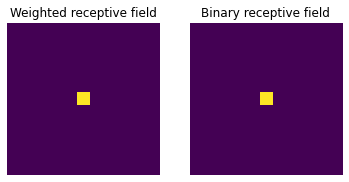

In [3]:
# visualize the receptive field for VerticalStackConv and HorizontalStackConv
# we can compute the gradients of the input to imshow the receptive field

inp_img = torch.zeros(1, 1, 11, 11)
inp_img.requires_grad_()

def show_center_recep_field(img, out):
    """
    Calculates the gradients of the input with respect to the output center pixel,
    and visualizes the overall receptive field.
    Inputs:
        img - Input image for which we want to calculate the receptive field on.
        out - Output features/loss which is used for backpropagation, and should be
              the output of the network/computation graph.
    """
    # Determine gradients, the center pixel
    loss = out[0, :, img.shape[2]//2, img.shape[3]//2].sum() # L1 loss for simplicity
    # Retain graph as we want to stack multiple layers and show the receptive field of all of them
    loss.backward(retain_graph=True)
    img_grads = img.grad.abs()
    img.grad.fill_(0) # Reset grads

    # Plot receptive field
    img = img_grads.squeeze().cpu().numpy()
    fig, ax = plt.subplots(1, 2)
    pos = ax[0].imshow(img)
    ax[1].imshow(img > 0)
    # Mark the center pixel in red if it doesn't have any gradients,
    # which is the case for standard autoregressive models)
    show_center = (img[img.shape[0]//2, img.shape[1]//2] == 0)
    if show_center:
        center_pixel = np.zeros(img.shape + (4,))
        center_pixel[center_pixel.shape[0]//2, center_pixel.shape[1]//2, :] = np.array([1.0, 0.0, 0.0, 1.0])
    for i in range(2):
        ax[i].axis('off')
        if show_center:
            ax[i].imshow(center_pixel)
    ax[0].set_title("Weighted receptive field")
    ax[1].set_title("Binary receptive field")
    plt.show()
    plt.close()

# we don't use conv, so the receptive field is only the center pixel
show_center_recep_field(inp_img, inp_img)

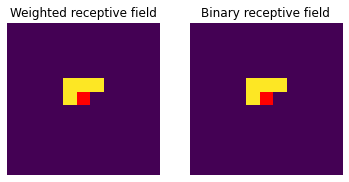

In [4]:
# we first visualize the original masked_conv
kernel_size = 3
mask_A = torch.zeros((3, 3))
mask_A[:kernel_size//2, :] = 1.0
mask_A[kernel_size//2, :kernel_size//2] = 1.0

masked_conv = MaskedConv2d(mask_A, 1, 1, 3, padding=1)
masked_conv.weight.data.fill_(1)
masked_conv.bias.data.fill_(0)
masked_conv_img = masked_conv(inp_img)
show_center_recep_field(inp_img, masked_conv_img)

Layer 2


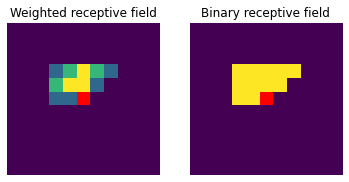

Layer 3


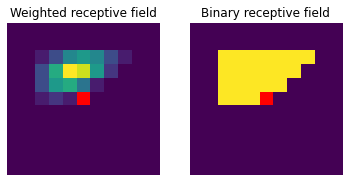

Layer 4


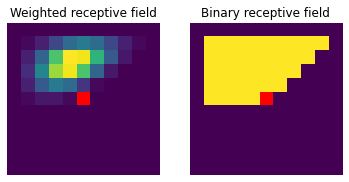

Layer 5


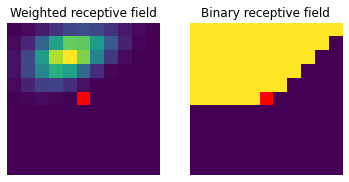

In [5]:
# use mask_type B
mask_B = mask_A.clone()
mask_B[kernel_size//2, kernel_size//2] = 1.
masked_conv = MaskedConv2d(mask_B, 1, 1, 3, padding=1)
masked_conv.weight.data.fill_(1)
masked_conv.bias.data.fill_(0)

for l_idx in range(4):
    masked_conv_img = masked_conv(masked_conv_img)
    print(f"Layer {l_idx+2}")
    show_center_recep_field(inp_img, masked_conv_img)
    
# there is a “blind spot” on the right upper side

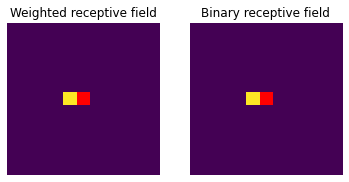

In [6]:
# visualize HorizontalStackConv
horiz_conv = HorizontalStackConv("A", 1, 1, 3, padding=1)
horiz_conv.weight.data.fill_(1)
horiz_conv.bias.data.fill_(0)
horiz_img = horiz_conv(inp_img)
show_center_recep_field(inp_img, horiz_img)

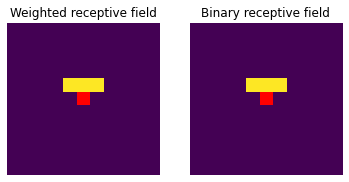

In [7]:
# visualize VerticalStackConv
vert_conv = VerticalStackConv("A", 1, 1, 3, padding=1)
vert_conv.weight.data.fill_(1)
vert_conv.bias.data.fill_(0)
vert_img = vert_conv(inp_img)
show_center_recep_field(inp_img, vert_img)

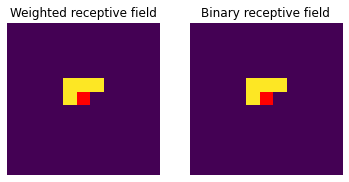

In [8]:
# combine the two by adding, which is what we expect
horiz_img = vert_img + horiz_img
show_center_recep_field(inp_img, horiz_img)

Layer 2


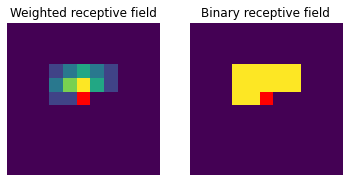

Layer 3


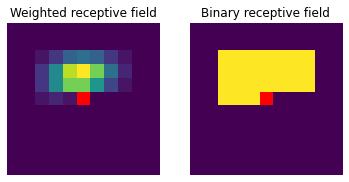

Layer 4


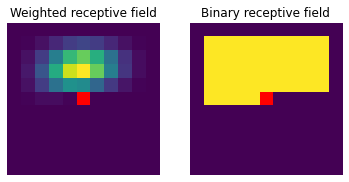

Layer 5


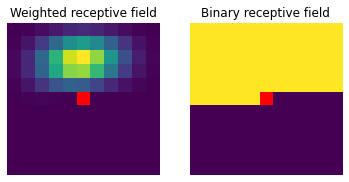

In [9]:
# Initialize convolutions with equal weight to all input pixels
horiz_conv = HorizontalStackConv("B", 1, 1, 3, padding=1)
horiz_conv.weight.data.fill_(1)
horiz_conv.bias.data.fill_(0)
vert_conv = VerticalStackConv("B", 1, 1, 3, padding=1)
vert_conv.weight.data.fill_(1)
vert_conv.bias.data.fill_(0)

# note we use mask_type A for the first layer, but after first layer we should use mask_type B

# We reuse our convolutions for the 4 layers here. Note that in a standard network,
# we don't do that, and instead learn 4 separate convolution. As this cell is only for
# visualization purposes, we reuse the convolutions for all layers.
for l_idx in range(4):
    vert_img = vert_conv(vert_img)
    horiz_img = horiz_conv(horiz_img) + vert_img
    print(f"Layer {l_idx+2}")
    show_center_recep_field(inp_img, horiz_img)

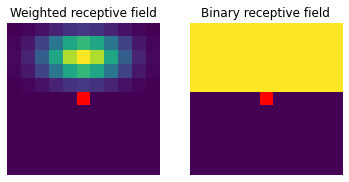

In [10]:
# check the vert_conv
show_center_recep_field(inp_img, vert_img)

In [11]:
class GatedMaskedConv(nn.Module):

    def __init__(self, in_channels, kernel_size=3, dilation=1):
        """
        Gated Convolution block implemented the computation graph shown above.
        """
        super().__init__()
        
        padding = dilation * (kernel_size - 1) // 2
        self.conv_vert = VerticalStackConv("B", in_channels, 2*in_channels, kernel_size, padding=padding,
                                          dilation=dilation)
        self.conv_horiz = HorizontalStackConv("B", in_channels, 2*in_channels, kernel_size, padding=padding,
                                             dilation=dilation)
        self.conv_vert_to_horiz = nn.Conv2d(2*in_channels, 2*in_channels, kernel_size=1)
        self.conv_horiz_1x1 = nn.Conv2d(in_channels, in_channels, kernel_size=1)

    def forward(self, v_stack, h_stack):
        # Vertical stack (left)
        v_stack_feat = self.conv_vert(v_stack)
        v_val, v_gate = v_stack_feat.chunk(2, dim=1)
        v_stack_out = torch.tanh(v_val) * torch.sigmoid(v_gate)

        # Horizontal stack (right)
        h_stack_feat = self.conv_horiz(h_stack)
        h_stack_feat = h_stack_feat + self.conv_vert_to_horiz(v_stack_feat)
        h_val, h_gate = h_stack_feat.chunk(2, dim=1)
        h_stack_feat = torch.tanh(h_val) * torch.sigmoid(h_gate)
        h_stack_out = self.conv_horiz_1x1(h_stack_feat)
        h_stack_out = h_stack_out + h_stack

        return v_stack_out, h_stack_out

In [12]:
# GatedPixelCNN

class GatedPixelCNN(nn.Module):
    
    def __init__(self, in_channels, channels, out_channels):
        super().__init__()
        
        # Initial first conv with mask_type A
        self.conv_vstack = VerticalStackConv("A", in_channels, channels, 3, padding=1)
        self.conv_hstack = HorizontalStackConv("A", in_channels, channels, 3, padding=1)
        # Convolution block of PixelCNN. use dilation instead of 
        # downscaling used in the encoder-decoder architecture in PixelCNN++
        self.conv_layers = nn.ModuleList([
            GatedMaskedConv(channels),
            GatedMaskedConv(channels, dilation=2),
            GatedMaskedConv(channels),
            GatedMaskedConv(channels, dilation=4),
            GatedMaskedConv(channels),
            GatedMaskedConv(channels, dilation=2),
            GatedMaskedConv(channels)
        ])
        
        # Output classification convolution (1x1)
        self.conv_out = nn.Conv2d(channels, out_channels, kernel_size=1)
        
    def forward(self, x):
        # first convolutions
        v_stack = self.conv_vstack(x)
        h_stack = self.conv_hstack(x)
        # Gated Convolutions
        for layer in self.conv_layers:
            v_stack, h_stack = layer(v_stack, h_stack)
        # 1x1 classification convolution
        # Apply ELU before 1x1 convolution for non-linearity on residual connection
        out = self.conv_out(F.elu(h_stack))
        return out

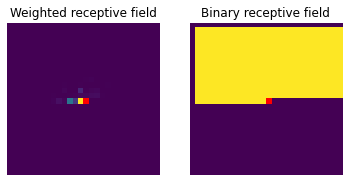

In [13]:
# visualize GaGatedPixelCNN
test_model = GatedPixelCNN(1, 64, 1)
inp = torch.zeros(1, 1, 28, 28)
inp.requires_grad_()
out = test_model(inp)
show_center_recep_field(inp, out.squeeze(dim=2))
del inp, out, test_model

In [14]:
image_size = 28
in_channels = 1
out_channels = 1
channels = 128 # hidden channels

batch_size = 64
epochs = 10

transform=transforms.Compose([
    transforms.ToTensor()
])

dataset1 = datasets.MNIST('/data', train=True, download=True,
                       transform=transform)
dataset2 = datasets.MNIST('/data', train=False,
                       transform=transform)
train_loader = torch.utils.data.DataLoader(dataset1, batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(dataset2, batch_size=batch_size)

model = GatedPixelCNN(in_channels, channels, out_channels).cuda()
optimizer = torch.optim.Adam(model.parameters(), lr=5e-4)

In [15]:
print_freq = 1000
for epoch in range(epochs):
    print("Start training epoch {}".format(epoch,))
    for i, (images, labels) in enumerate(train_loader):
        images = (images > 0.33).float() # convert to 0, 1
        images = images.cuda()
        logits = model(images)
        loss = F.binary_cross_entropy_with_logits(logits, images)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        if (i + 1) % print_freq == 0 or (i + 1) == len(train_loader):
            print("\t [{}/{}]: loss {}".format(i, len(train_loader), loss.item())) 

Start training epoch 0
	 [937/938]: loss 0.07492595911026001
Start training epoch 1
	 [937/938]: loss 0.07849381119012833
Start training epoch 2
	 [937/938]: loss 0.0740843266248703
Start training epoch 3
	 [937/938]: loss 0.07141074538230896
Start training epoch 4
	 [937/938]: loss 0.07250042259693146
Start training epoch 5
	 [937/938]: loss 0.07237093895673752
Start training epoch 6
	 [937/938]: loss 0.07213447242975235
Start training epoch 7
	 [937/938]: loss 0.06828761845827103
Start training epoch 8
	 [937/938]: loss 0.07389771193265915
Start training epoch 9
	 [937/938]: loss 0.07310089468955994


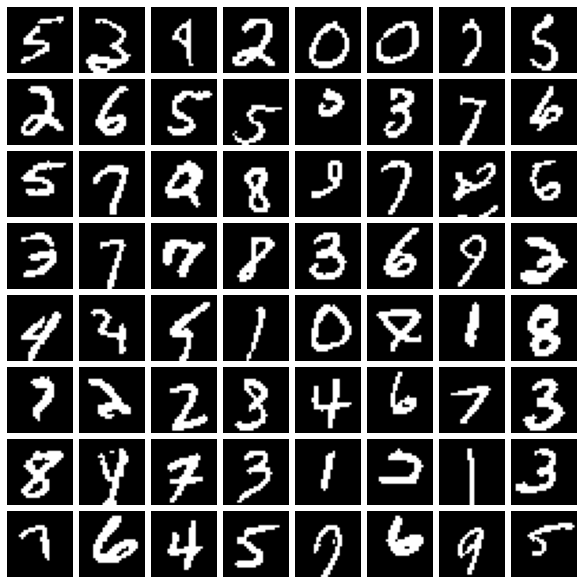

In [16]:
## generate new images by PixelCNN
n_cols, n_rows = 8, 8
C = 1
H = 28
W = 28

# Create an empty array of pixels.
pixels = torch.zeros(n_cols * n_rows, C, H, W).cuda()

model.eval()
with torch.no_grad():
    # Iterate over the pixels because generation has to be done sequentially pixel by pixel.
    for h in range(H):
        for w in range(W):
            for c in range(C):
                # Feed the whole array and retrieving the pixel value probabilities for the next pixel.
                logits = model(pixels)[:, c, h, w]
                probs = logits.sigmoid()
                # Use the probabilities to pick pixel values and append the values to the image frame.
                pixels[:, c, h, w] = torch.bernoulli(probs)
                
generated_imgs = pixels.cpu().numpy()
generated_imgs = np.array(generated_imgs * 255, dtype=np.uint8).reshape(n_rows, n_cols, H, W)
    
fig = plt.figure(figsize=(8, 8), constrained_layout=True)
gs = fig.add_gridspec(n_rows, n_cols)
for n_col in range(n_cols):
    for n_row in range(n_rows):
        f_ax = fig.add_subplot(gs[n_row, n_col])
        f_ax.imshow(generated_imgs[n_row, n_col], cmap="gray")
        f_ax.axis("off")

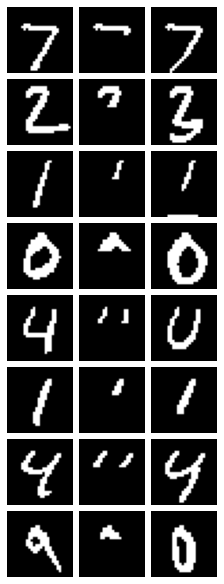

In [17]:
# we can use pixelcnn to autocomplete images
test_loader_iter = iter(test_loader)
images, labels = next(test_loader_iter)

n_samples = 8
n_rows = 12  # the number of rows to keep

images = (images[:n_samples] > 0.33).float() # convert to 0, 1

sub_images = images.clone()
sub_images[:, :, n_rows:, :] = 0 # mask some pixels
pixels = sub_images.cuda()


with torch.no_grad():
    # Iterate over the pixels because generation has to be done sequentially pixel by pixel.
    for h in range(n_rows, H):
        for w in range(W):
            for c in range(C):
                # Feed the whole array and retrieving the pixel value probabilities for the next pixel.
                logits = model(pixels)[:, c, h, w]
                probs = logits.sigmoid()
                # Use the probabilities to pick pixel values and append the values to the image frame.
                pixels[:, c, h, w] = torch.bernoulli(probs)
                
original_imgs = images.cpu().numpy()
original_imgs = np.array(original_imgs * 255, dtype=np.uint8).reshape(n_samples, H, W)
sub_imgs = sub_images.cpu().numpy()
sub_imgs = np.array(sub_imgs * 255, dtype=np.uint8).reshape(n_samples, H, W)
generated_imgs = pixels.cpu().numpy()
generated_imgs = np.array(generated_imgs * 255, dtype=np.uint8).reshape(n_samples, H, W)


fig = plt.figure(figsize=(3, 8), constrained_layout=True)
gs = fig.add_gridspec(n_samples, 3)
for n_row in range(n_samples):
    f_ax = fig.add_subplot(gs[n_row, 0])
    f_ax.imshow(original_imgs[n_row], cmap="gray")
    f_ax.axis("off")
    f_ax = fig.add_subplot(gs[n_row, 1])
    f_ax.imshow(sub_imgs[n_row], cmap="gray")
    f_ax.axis("off")
    f_ax = fig.add_subplot(gs[n_row, 2])
    f_ax.imshow(generated_imgs[n_row], cmap="gray")
    f_ax.axis("off")